Import libraries required and read in the data.
Look at the structure of the dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
pd.set_option('display.max_columns', 500)
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,NaN,Straight / Heterosexual,No,"No, not at all",NaN,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,NaN,NaN,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,NaN,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Once a decade,NaN,NaN,No,NaN,NaN,NaN,Stack Overflow (public Q&A for anyone who codes),NaN,Linux-based,NaN,NaN,NaN,NaN,NaN,Yes,"Yes, somewhat",A few times per month or weekly,Daily or almost daily,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,White or of European descent,Man,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not at all important/not necessary,Curious about other opportunities;Wanting to w...,NaN,Once a year,Not sure,Yes,Yes,Occasionally: 1-2 days per quarter but less th...,NaN,NaN,Stack Overflow (public Q&A for anyone who code...,NaN,Lin

In [3]:
df.shape

(64461, 61)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
Respondent                      64461 non-null int64
MainBranch                      64162 non-null object
Hobbyist                        64416 non-null object
Age                             45446 non-null float64
Age1stCode                      57900 non-null object
CompFreq                        40069 non-null object
CompTotal                       34826 non-null float64
ConvertedComp                   34756 non-null float64
Country                         64072 non-null object
CurrencyDesc                    45472 non-null object
CurrencySymbol                  45472 non-null object
DatabaseDesireNextYear          44070 non-null object
DatabaseWorkedWith              49537 non-null object
DevType                         49370 non-null object
EdLevel                         57431 non-null object
Employment                      63854 non-null object
Ethnicity                

See how many females took the survey since I'd like to make comparison of responses between genders.

Man                                                        46013
Woman                                                       3844
Non-binary, genderqueer, or gender non-conforming            385
Man;Non-binary, genderqueer, or gender non-conforming        121
Woman;Non-binary, genderqueer, or gender non-conforming       92
Name: Gender, dtype: int64

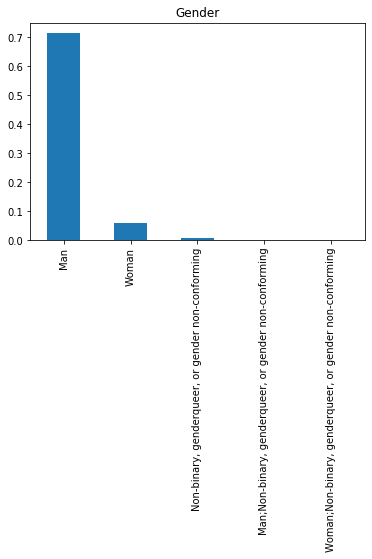

In [5]:
count_vals = df.Gender.value_counts() #Provide a pandas series of the counts for each gender

(count_vals[:5]/df.shape[0]).plot(kind="bar");
plt.title("Gender");

count_vals[:5]/df.shape[0]
count_vals[:5]

There's only 6% female respondents, but it's still almost 4,000 individual women, so I'll use it.

I'd like to find out why/how developers seek new jobs. In particular, how does this change for minorities?
Start exploring questions related to seeking work.

In [6]:
df.NEWJobHunt.value_counts()

Curious about other opportunities;Better compensation;Wanting to work with new technologies;Growth or leadership opportunities                                                                                                                                                                                               1127
Curious about other opportunities;Better compensation;Better work/life balance;Wanting to work with new technologies;Growth or leadership opportunities                                                                                                                                                                      1121
Better compensation                                                                                                                                                                                                                                                                                                           803
Curious about other opportunities;

This must be cleaned. Make a function for future columns that will need to be similarly cleaned.

In [7]:
from collections import defaultdict

possible_vals_NEWJobHunt = ["Just because", "Having a bad day (or week or month) at work",
                 "Wanting to share accomplishments with a wider network",
                 "Curious about other opportunities", "Better compensation",
                 "Trouble with my teammates", "Trouble with my direct manager",
                 "Trouble with leadership at my company", "Better work/life balance",
                 "Wanting to work with new technologies", "Growth or leadership opportunities",
                 "Looking to relocate", "Other"]

def total_count(df, col1, col2, look_for): # Copied from helper functions in Lesson 1
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of values
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the value is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

def clean_and_plot(df, possible_vals, col_to_clean='NEWJobHunt', title='New Job Seeking Drivers', plot=True): # Copied from Lesson 1, adapted for NEWJobHunt variable
    '''
    INPUT 
        df - a dataframe holding the col_to_clean column
        col_to_clean - column in df for which we are finding counts
        possible_vals - possible values to look for in col_to_clean
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        (Optionally) displays a plot of pretty things related to the col_to_clean column.
        (Optionally) ax - axis handle to the plot
    '''
    study = df[col_to_clean].value_counts().reset_index()
    study.rename(columns={'index': 'value', col_to_clean: 'count'}, inplace=True)
    study_df = total_count(study, 'value', 'count', possible_vals)

    study_df.set_index('value', inplace=True)
    if plot:
        ax=(study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
#         plt.show()
    out_df = study_df/study_df.sum()
    
    try:
        out_df = out_df[0] # in case it comes out as a tuple
    except:
        out_df = out_df
    
    if plot:
        return out_df,ax
    else:
        return out_df

#### Question 1: What factors drive the respondents to seek new jobs?

,count
value,
Better compensation,0.170001
Wanting to work with new technologies,0.142220
Curious about other opportunities,0.138870
Growth or leadership opportunities,0.128663
Better work/life balance,0.117284
Trouble with leadership at my company,0.065119
Looking to relocate,0.063883
Having a bad day (or week or month) at work,0.049303
Trouble with my direct manager,0.041332


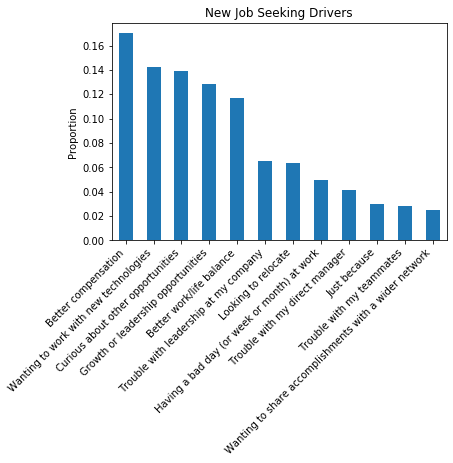

In [8]:
drivers_df,ax = clean_and_plot(df, possible_vals_NEWJobHunt)
ax.set_xticklabels(list(drivers_df.index),rotation=45, ha='right');
ax.set_xlabel('')
ax.set_ylabel('Proportion')
drivers_df

#### Question 2: What factors are most important when choosing a new job?

The next response I want to look at is the most important factors when choosing between 2 job positions.
The respondents were asked to choose 3 factors, assuming the 2 jobs had the same compensation, benefits, and location.

In [9]:
df.JobFactors.value_counts()

Flex time or a flexible schedule;Languages, frameworks, and other technologies I’d be working with;Remote work options                                2777
Languages, frameworks, and other technologies I’d be working with;Office environment or company culture;Opportunities for professional development    2570
Flex time or a flexible schedule;Languages, frameworks, and other technologies I’d be working with;Office environment or company culture              2508
Flex time or a flexible schedule;Languages, frameworks, and other technologies I’d be working with;Opportunities for professional development         1666
Flex time or a flexible schedule;Office environment or company culture;Opportunities for professional development                                     1650
                                                                                                                                                      ... 
Diversity of the company or organization;Flex time or a flexible sched

,count
value,
Flex time or a flexible schedule,0.277151
Opportunities for professional development,0.261345
Remote work options,0.210026
How widely used or impactful my work output would be,0.131524
Family friendliness,0.076608
Diversity of the company or organization,0.043346


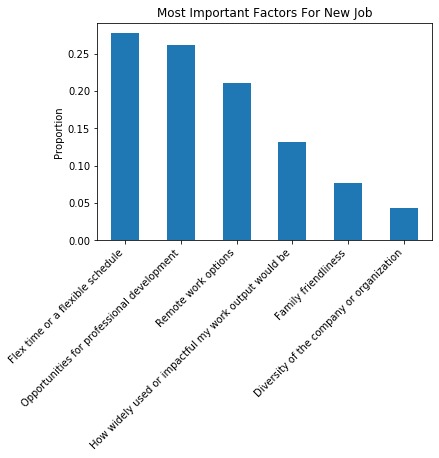

In [10]:
possible_vals_JobFactors = ["Remote work options", "Office environment of company culture",
                 "Financial performance or funding status of company or organization",
                 "Opportunities for professional development", "Diversity of the company or organization",
                 "How widely used or impactful my work output would be",
                 "Industry that I'd be working in", "Specific department or team I'd be working on",
                 "Flex time or a flexible schedule", "Languages, frameworks, and other technologies I'd be working with",
                 "Family friendliness"]

factors_df,ax = clean_and_plot(df, possible_vals_JobFactors, 'JobFactors', 'Most Important Factors For New Job')
ax.set_xticklabels(list(factors_df.index),rotation=45, ha='right');
ax.set_xlabel('')
ax.set_ylabel('Proportion')
factors_df

See how many respondents are even open to new job opportunities.

['I’m not actively looking, but I am open to new opportunities', 'I am not interested in new job opportunities', 'I am actively looking for a job']


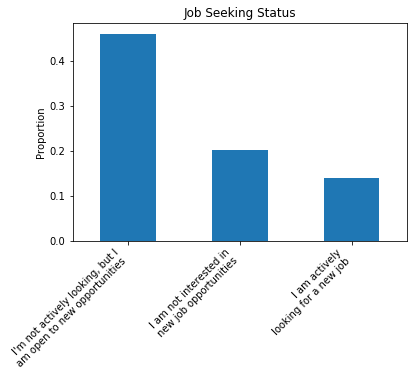

In [11]:
count_vals = df.JobSeek.value_counts() #Provide a pandas series of the counts for each job seek status
print(list(count_vals.index))

ax = (count_vals[:10]/df.shape[0]).plot(kind="bar");
plt.title("Job Seeking Status");
# ax.set_xticklabels(list(count_vals.index),rotation=45, ha='right');
xlabs = ['I\'m not actively looking, but I\nam open to new opportunities','I am not interested in\nnew job opportunities','I am actively\nlooking for a new job']
ax.set_xticklabels(xlabs,rotation=45, ha='right');
ax.set_xlabel('');
ax.set_ylabel('Proportion');

It looks like only 20% of respondents are not interested in taking on a new job, with most people at least open to a change. This information can be used as motivation for companies to use the information presented here to interest developers in taking a job with them.

#### Question 3: How does the above analysis change for minority developers?

Now I'd like to look at the results above for minority respondents. Is there something a company might be able to do to attract more diverse applicants in particular?

First look at the breakdown to determine who should be included in the minority group according to race.

White or of European descent                                                                                     0.454818
South Asian                                                                                                      0.069298
Hispanic or Latino/a/x                                                                                           0.034998
Black or of African descent                                                                                      0.026217
Southeast Asian                                                                                                  0.026155
East Asian                                                                                                       0.026078
Middle Eastern                                                                                                   0.025163
Hispanic or Latino/a/x;White or of European descent                                                              0.011837
Middle Eastern;White or 

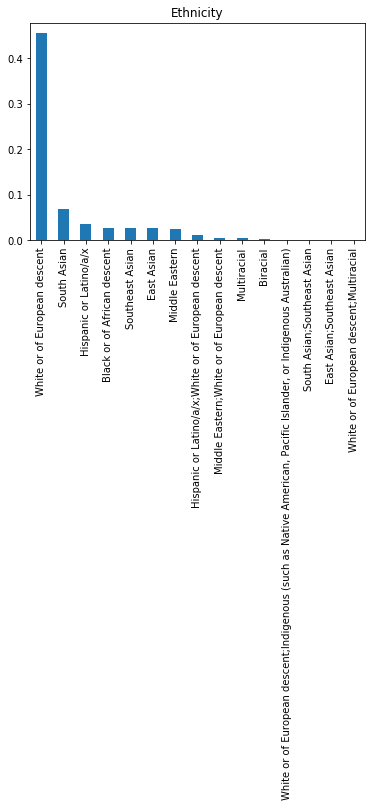

In [12]:
count_vals = df.Ethnicity.value_counts() #Provide a pandas series of the counts for each ethnicity

(count_vals[:15]/df.shape[0]).plot(kind="bar");
plt.title("Ethnicity");

count_vals[:15]/df.shape[0]

Based on the above results, I will take any race other than white (of European descent), add all women, and that will be the minority group I will consider. So, the non-minority group will be made up exclusively of white men.

Start by dividing the dataset.

In [13]:
df_whitemen = df[(df.Gender == 'Man') & (df.Ethnicity == 'White or of European descent')]

In [14]:
df_minorities = df[~((df.Gender == 'Man') & (df.Ethnicity == 'White or of European descent'))]
df_minorities.shape

(37865, 61)

In [15]:
def make_chart(num_x_vals,df1,df2,title,leg=['White Men','Minorities']): # adapted from https://chrisalbon.com/python/data_visualization/matplotlib_grouped_bar_plot/
    # For now, make sure df1 and df2 indices are in the same order
    # Later, we can make df2 have same order as df1, which should be in some order that makes sense (decreasing for example)
    '''
    INPUT:
    num_x_vals - number of x-axis values you want to plot
    df1 - dataframe of first group
    df2 - dataframe of second group
    title - title for output plot
    (Optionally) leg - list of legend annotations

    OUTPUT:
    Displays a double bar plot of the 2 datasets
    '''
    
    
    df1_vals = []
    for i in range(df1.values.shape[0]):
        df1_vals.append(df1.values[i][0])
    df2_vals = []
    for i in range(df2.values.shape[0]):
        df2_vals.append(df2.values[i][0])
    
    # Setting the positions and width for the bars
    pos = list(range(num_x_vals)) 
    width = 0.25
#     width = 0.5

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10,5))

    # Create a bar with pre_score data,
    # in position pos,
    plt.bar([p + width for p in pos], 
            #using df['pre_score'] data,
            df1_vals,
            # of width
            width,
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='#EE3224', 
            # with label the first value in first_name
            label=df1.index[0])

    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.bar([p + width*2 for p in pos], 
            #using df['mid_score'] data,
            df2_vals,
            # of width
            width, 
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='#F78F1E', 
            # with label the second value in first_name
            label=df1.index[1])

    # Set the y axis label
    ax.set_ylabel('Proportion')

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])

    # Set the labels for the x ticks
    ax.set_xticklabels(list(df1.index),rotation=90)
#     ax.xaxis.set_label_coords(-0.3, 0.5) #added as test

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
#     plt.ylim([0, max(df1 + df2)])

    # Adding the legend and showing the plot
    plt.legend(leg, loc='upper right')
#     plt.grid()
    plt.show()

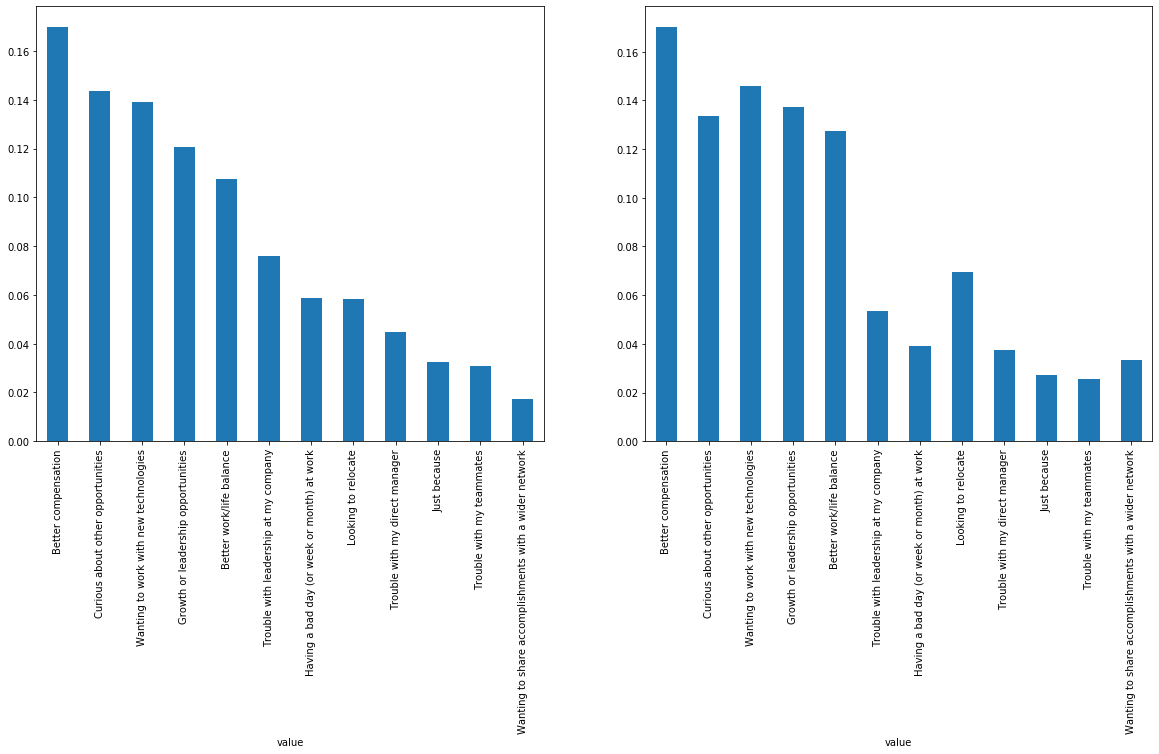

In [16]:
drivers_df_whitemen = clean_and_plot(df_whitemen, possible_vals_NEWJobHunt,plot=False)
drivers_df_minorities = clean_and_plot(df_minorities, possible_vals_NEWJobHunt,plot=False)

# drivers_df_whitemen.plot(kind='bar', legend=None);
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

drivers_df_whitemen.plot(ax=ax[0],kind='bar', legend=None);
# drivers_df_minorities.plot(ax=ax[1],kind='bar', legend=None);
drivers_order = list(drivers_df_whitemen.index)
drivers_df_minorities.loc[drivers_order].plot(ax=ax[1], kind="bar", legend=False);

Make a chart that's easier to compare the 2 groups.

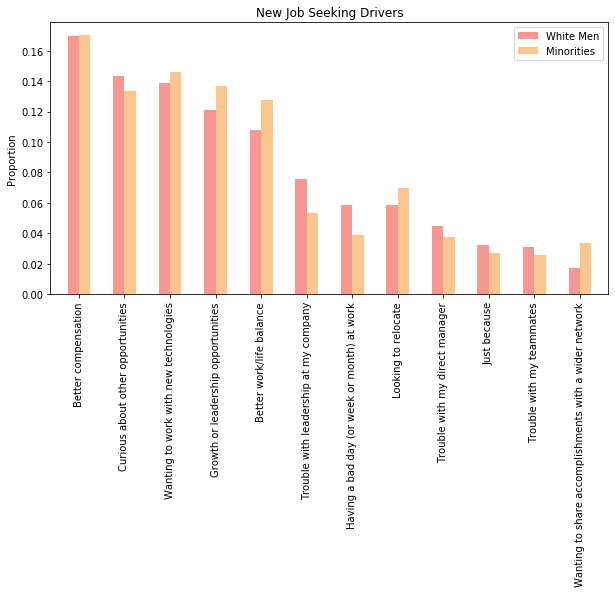

In [17]:
make_chart(drivers_df_whitemen.shape[0],drivers_df_whitemen,drivers_df_minorities.loc[drivers_order],'New Job Seeking Drivers')

Now look at the same thing, but isolating just women in one group, and comparing them to all men.

In [18]:
df_men = df[df.Gender == 'Man']
df_women = df[df.Gender == 'Woman']

drivers_df_men = clean_and_plot(df_men, possible_vals_NEWJobHunt,plot=False)
drivers_df_women = clean_and_plot(df_women, possible_vals_NEWJobHunt,plot=False)

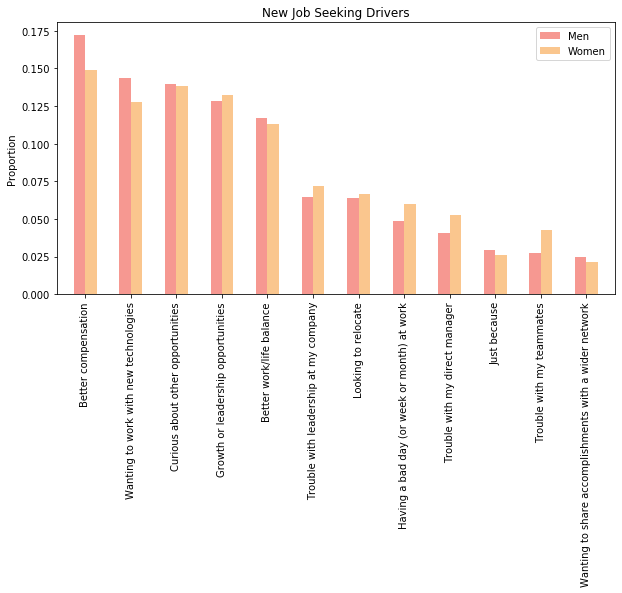

In [19]:
drivers_men_order = list(drivers_df_men.index)
make_chart(drivers_df_men.shape[0],drivers_df_men,drivers_df_women.loc[drivers_men_order],'New Job Seeking Drivers',leg=['Men','Women'])

The clearest plot to show differences may be one that just has a bar indicating difference between the groups, ordered by largest difference. Make a function for plotting that below, then use for white men vs. minorities and men vs. women.

In [20]:
def plot_difference_chart(df1,df2):
    '''
    INPUT:
    df1 - dataframe of first group
    df2 - dataframe of second group

    OUTPUT:
    Displays a bar plot of differences between values in df1 and df2 (df1-df2)
    ax - axis handle to plot
    df_drivers_dem - dataframe of df1 combined with df2 with addition of a difference column
    '''
    
    df1_vals = []
    for i in range(df1.values.shape[0]):
        df1_vals.append(df1.values[i][0])
    df2_vals = []
    for i in range(df2.values.shape[0]):
        df2_vals.append(df2.values[i][0])

    index = list(df1.index)

    d = {'factor': index, 'group1': df1_vals, 'group2': df2_vals}
    df_drivers_dem = pd.DataFrame(data=d)
    df_drivers_dem.set_index('factor', inplace=True)

#     df_drivers_dem['difference'] = df_drivers_dem.columns[1]-df_drivers_dem.columns[0]
    df_drivers_dem['difference'] = df_drivers_dem.group2-df_drivers_dem.group1
    
    df_drivers_dem

    # plot difference
    ax = df_drivers_dem.difference.sort_values(ascending=False).plot(kind='bar');
    ax.grid(axis='y');
    ax.set_xticklabels(df_drivers_dem.difference.sort_values(ascending=False).index,rotation=45, ha='right');
    
    return ax,df_drivers_dem

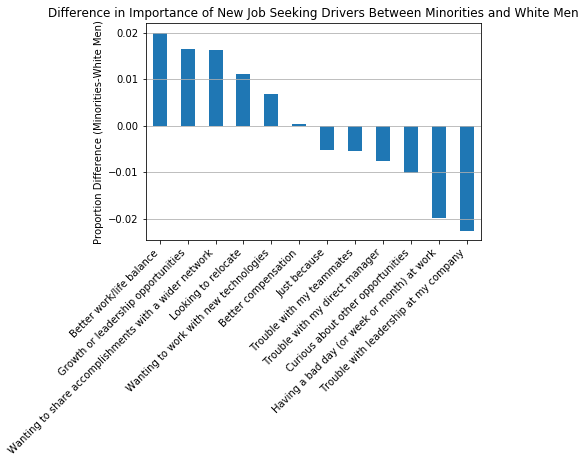

In [21]:
ax,df_drivers_dem = plot_difference_chart(drivers_df_whitemen,drivers_df_minorities.loc[drivers_order])
ax.set(xlabel="", ylabel="Proportion Difference (Minorities-White Men)", title="Difference in Importance of New Job Seeking Drivers Between Minorities and White Men");

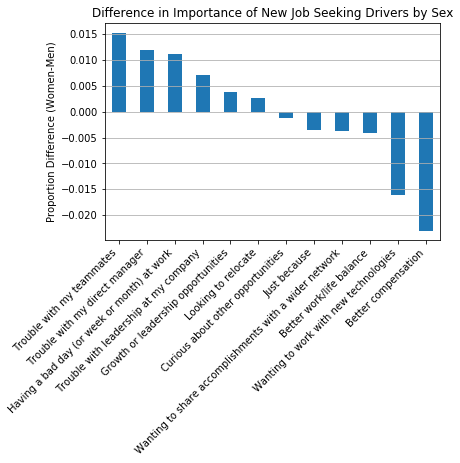

In [22]:
ax,df_drivers_dem = plot_difference_chart(drivers_df_men,drivers_df_women.loc[drivers_men_order])
ax.set(xlabel="", ylabel="Proportion Difference (Women-Men)", title="Difference in Importance of New Job Seeking Drivers by Sex");

Now do the same for the question about most important factors for a new job.

,count
value,
Flex time or a flexible schedule,0.292025
Opportunities for professional development,0.243004
Remote work options,0.223339
How widely used or impactful my work output would be,0.135817
Family friendliness,0.078920
Diversity of the company or organization,0.026894


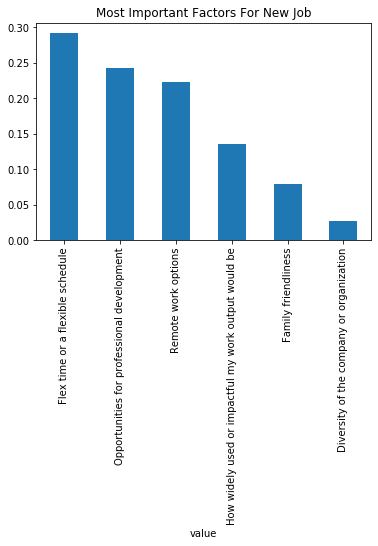

In [23]:
factors_df_whitemen,ax = clean_and_plot(df_whitemen, possible_vals_JobFactors, 'JobFactors', 'Most Important Factors For New Job')
factors_df_whitemen

,count
value,
Opportunities for professional development,0.279247
Flex time or a flexible schedule,0.262632
Remote work options,0.197031
How widely used or impactful my work output would be,0.127333
Family friendliness,0.074351
Diversity of the company or organization,0.059405


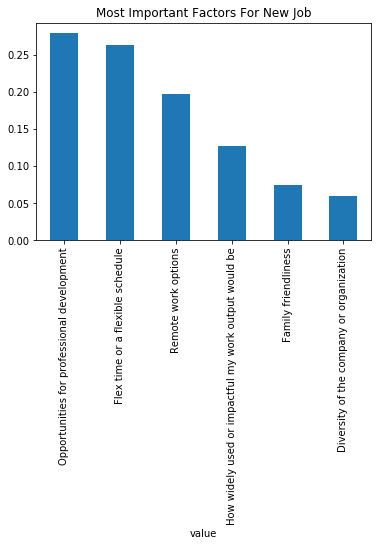

In [24]:
factors_df_minorities,ax = clean_and_plot(df_minorities, possible_vals_JobFactors, 'JobFactors', 'Most Important Factors For New Job')
factors_df_minorities

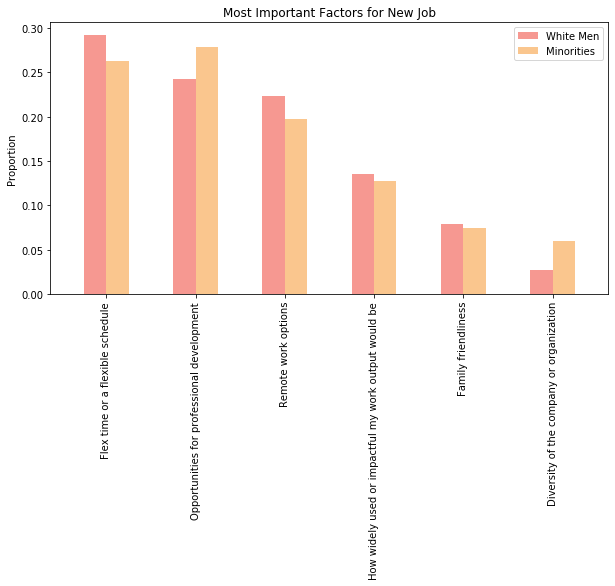

In [25]:
factors_order = list(factors_df_whitemen.index)
make_chart(factors_df_whitemen.shape[0],factors_df_whitemen,factors_df_minorities.loc[factors_order],'Most Important Factors for New Job')

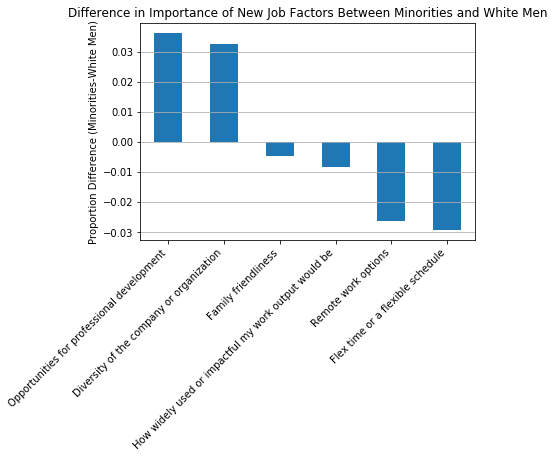

In [26]:
ax,df_factors_dem = plot_difference_chart(factors_df_whitemen,factors_df_minorities.loc[factors_order])
ax.set(xlabel="", ylabel="Proportion Difference (Minorities-White Men)", title="Difference in Importance of New Job Factors Between Minorities and White Men");

In [27]:
factors_df_men = clean_and_plot(df_men, possible_vals_JobFactors,'JobFactors','Most Important Factors For New Job',plot=False)
factors_df_women = clean_and_plot(df_women, possible_vals_JobFactors,'JobFactors', 'Most Important Factors For New Job',plot=False)

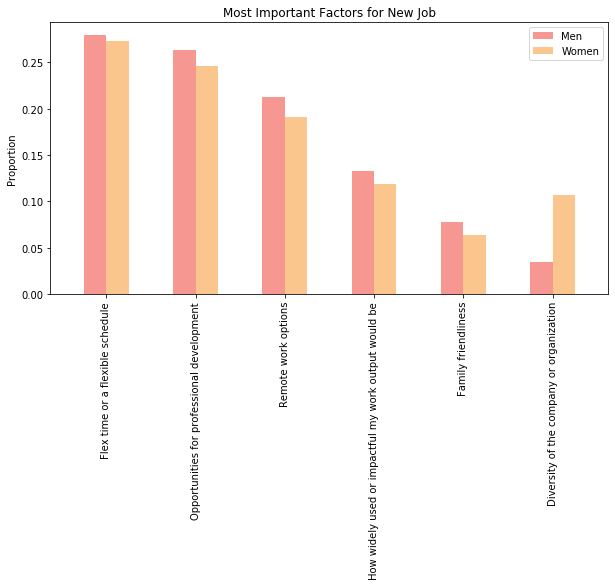

In [28]:
factors_men_order = list(factors_df_men.index)
make_chart(factors_df_men.shape[0],factors_df_men,factors_df_women.loc[factors_men_order],'Most Important Factors for New Job',leg=['Men','Women'])

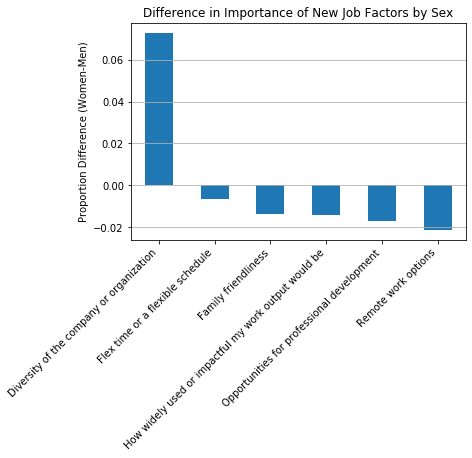

In [29]:
ax,df_factors_dem = plot_difference_chart(factors_df_men,factors_df_women.loc[factors_men_order])
ax.set(xlabel="", ylabel="Proportion Difference (Women-Men)", title="Difference in Importance of New Job Factors by Sex");

In [30]:
# possible_vals_NEWJobHuntResearch = ['Read company media, such as employee blogs or company culture videos',
#                                     'Company reviews from third party sites (e.g. Glassdoor, Blind)',
#                                     'Publicly available financial information (e.g. Crunchbase)',
#                                     'Personal network - friends or family',
#                                     'Read other media like news articles, founder profiles, etc. about the company',
#                                     'Directly asking current or past employees at the company', 'Other']

# factors_df = clean_and_plot(df, possible_vals_NEWJobHuntResearch, 'NEWJobHuntResearch', 'Method of Learning About New Company')
# factors_df

In [31]:
# methods_df_minorities = clean_and_plot(df_minorities, possible_vals_NEWJobHuntResearch, 'NEWJobHuntResearch', 'Method of Learning About New Company')
# methods_df_minorities

#### Conclusion and Comments

A caveat of this analysis is that no statistical analysis was done. To be able to say anything about the larger developer population, we would have to run two-proportioned Z tests for example.
However, we can say that there were small differences between minorities and non-minorities, and the difference between men and women on the importance of diversity in their new job is *likely* to be significant.

A full discussion can be found in the Medium article linked to in the README.md.